# Robotics and Motion

In [10]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import gym
from gym import spaces
import numpy as np
from stable_baselines3 import PPO
import torch

In [11]:
# Paths to the directories
smooth_surface_path = 'Indoor_Robot_Navigation_Data/outputs_2'
rough_surface_path = 'Indoor_Robot_Navigation_Data/outputs'

# Function to load JSON data from a folder
def load_json_files(folder_path):
    data = []
    for file in os.listdir(folder_path):
        if file.endswith(".json"):
            file_path = os.path.join(folder_path, file)
            with open(file_path, 'r') as f:
                try:
                    data.append(json.load(f))
                except json.JSONDecodeError as e:
                    print(f"Error reading {file_path}: {e}")
    return data

# Load data from both surfaces
smooth_data = load_json_files(smooth_surface_path)
rough_data = load_json_files(rough_surface_path)

In [12]:
# Add surface labels
for record in smooth_data:
    record['surface'] = 'smooth'

for record in rough_data:
    record['surface'] = 'rough'

In [13]:
# Function to extract and normalize 'data' key
def normalize_data(json_data, surface_label):
    all_data = []
    for record in json_data:
        # Extract 'data' and add 'surface' as a label
        for step in record['data']:
            step['surface'] = surface_label
            all_data.append(step)
    return pd.DataFrame(all_data)

# Normalize and combine data
smooth_df = normalize_data(smooth_data, 'smooth')
rough_df = normalize_data(rough_data, 'rough')

# Combine both DataFrames
robot_df = pd.concat([smooth_df, rough_df], ignore_index=True)

# Display dataset overview
print(robot_df.info())
print(robot_df.head())

# Save combined DataFrame to a CSV for inspection
robot_df.to_csv('combined_robot_data.csv', index=False)
print("Combined robot data saved to 'combined_robot_data.csv'")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13139 entries, 0 to 13138
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   direction     13139 non-null  object
 1   pose          13139 non-null  object
 2   brake         13139 non-null  int64 
 3   dists         13139 non-null  object
 4   angles        13139 non-null  object
 5   counts_left   13139 non-null  int64 
 6   horn          13139 non-null  int64 
 7   counts_right  13139 non-null  int64 
 8   surface       13139 non-null  object
dtypes: int64(4), object(5)
memory usage: 924.0+ KB
None
  direction                                               pose  brake  \
0        cw  {'seq': 6312, 'stamp': 1.6624593677536015e+18,...      0   
1        cw  {'seq': 6314, 'stamp': 1.6624593680242455e+18,...      0   
2        cw  {'seq': 6316, 'stamp': 1.6624593682817487e+18,...      0   
3        cw  {'seq': 6317, 'stamp': 1.6624593684172943e+18,...      0   
4       

In [14]:
# Load the previously saved CSV to avoid redundant processing
robot_df = pd.read_csv('combined_robot_data.csv')

# Display dataset overview
print(robot_df.info())
print(robot_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13139 entries, 0 to 13138
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   direction     13139 non-null  object
 1   pose          13139 non-null  object
 2   brake         13139 non-null  int64 
 3   dists         13139 non-null  object
 4   angles        13139 non-null  object
 5   counts_left   13139 non-null  int64 
 6   horn          13139 non-null  int64 
 7   counts_right  13139 non-null  int64 
 8   surface       13139 non-null  object
dtypes: int64(4), object(5)
memory usage: 924.0+ KB
None
  direction                                               pose  brake  \
0        cw  {'seq': 6312, 'stamp': 1.6624593677536015e+18,...      0   
1        cw  {'seq': 6314, 'stamp': 1.6624593680242455e+18,...      0   
2        cw  {'seq': 6316, 'stamp': 1.6624593682817487e+18,...      0   
3        cw  {'seq': 6317, 'stamp': 1.6624593684172943e+18,...      0   
4       

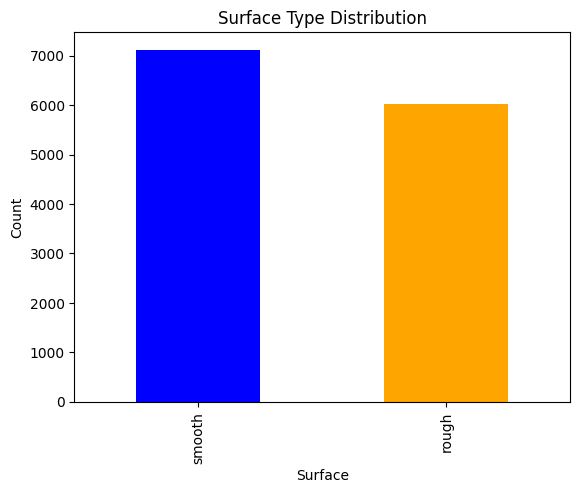

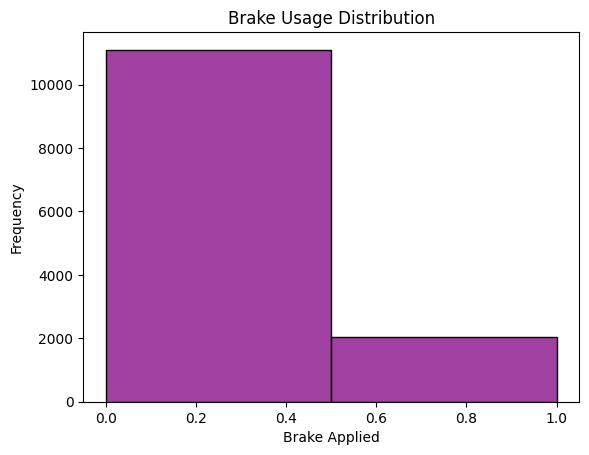

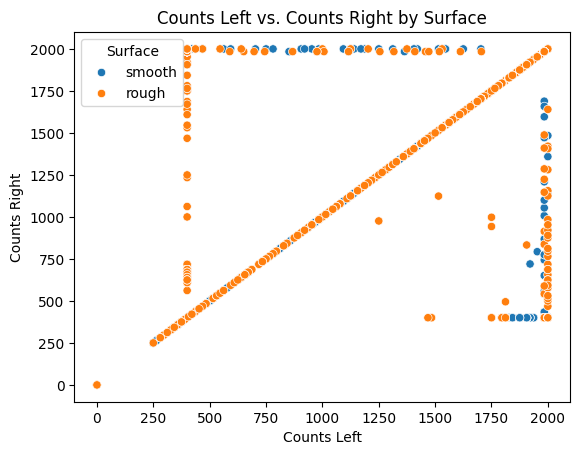

In [15]:
# Distribution of surface labels
robot_df['surface'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title("Surface Type Distribution")
plt.xlabel("Surface")
plt.ylabel("Count")
plt.show()

# Count distribution of brake usage
sns.histplot(data=robot_df, x='brake', kde=False, bins=2, color='purple')
plt.title("Brake Usage Distribution")
plt.xlabel("Brake Applied")
plt.ylabel("Frequency")
plt.show()

# Scatter plot of counts_left vs. counts_right colored by surface
sns.scatterplot(data=robot_df, x='counts_left', y='counts_right', hue='surface')
plt.title("Counts Left vs. Counts Right by Surface")
plt.xlabel("Counts Left")
plt.ylabel("Counts Right")
plt.legend(title='Surface')
plt.show()

In [16]:
#  Feature Engineering

# Calculate the minimum, mean, and maximum distances
robot_df['min_dist'] = robot_df['dists'].apply(lambda x: min(eval(x)))
robot_df['mean_dist'] = robot_df['dists'].apply(lambda x: np.mean(eval(x)))
robot_df['max_dist'] = robot_df['dists'].apply(lambda x: max(eval(x)))

# Create a speed ratio feature
robot_df['speed_ratio'] = robot_df['counts_left'] / robot_df['counts_right'].replace(0, np.nan)

# Drop unnecessary columns for modeling
robot_df = robot_df.drop(columns=['dists', 'angles', 'pose'], errors='ignore')

In [17]:
# Prepare Data for Modeling

# Encode the surface label
robot_df['surface_encoded'] = robot_df['surface'].map({'smooth': 0, 'rough': 1})

# Features and target
features = ['brake', 'counts_left', 'counts_right', 'min_dist', 'mean_dist', 'max_dist', 'speed_ratio']
X = robot_df[features].fillna(0)  # Replace NaNs if necessary
y = robot_df['surface_encoded']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a simple Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      2156
           1       0.87      0.82      0.85      1786

    accuracy                           0.87      3942
   macro avg       0.87      0.86      0.86      3942
weighted avg       0.87      0.87      0.87      3942



In [23]:
# Define Reinforcement Learning Environment

class RobotNavigationEnv(gym.Env):
    def __init__(self, data):
        super(RobotNavigationEnv, self).__init__()
        
        # Convert categorical columns to numerical
        self.data = data.copy()
        self.data['direction'] = self.data['direction'].map({'cw': 1, 'ccw': 0})
        self.data['surface'] = self.data['surface'].map({'smooth': 0, 'rough': 1})

        # Handle missing values or invalid data
        self.data = self.data.fillna(0)

        # Drop any non-numerical columns
        if 'pose' in self.data.columns:
            self.data.drop(columns=['pose'], inplace=True)

        self.current_index = 0

        # Define observation and action space
        self.observation_space = spaces.Box(
            low=0,
            high=1,
            shape=(self.data.shape[1] - 1,),  # Exclude target column
            dtype=np.float32
        )
        self.action_space = spaces.Discrete(3)  # [0: brake, 1: move forward, 2: turn]

        # Define rewards
        self.reward_system = {
            'safe': 10,
            'collision': -100,
            'goal_reached': 50,
            'out_of_bounds': -50
        }
        self.goal_reached = False

    def reset(self):
        self.current_index = 0
        self.goal_reached = False
        return self.data.iloc[self.current_index, :-1].values.astype(np.float32)

    def step(self, action):
        if self.goal_reached:
            done = True
            reward = self.reward_system['goal_reached']
            return self.data.iloc[self.current_index, :-1].values.astype(np.float32), reward, done, {}

        # Increment time step
        self.current_index += 1
        if self.current_index >= len(self.data):
            done = True
            reward = self.reward_system['out_of_bounds']
            observation = np.zeros(self.observation_space.shape, dtype=np.float32)
        else:
            done = False
            observation = self.data.iloc[self.current_index, :-1].values.astype(np.float32)

            # Simulate reward based on action
            if action == 0:  # Brake
                reward = self.reward_system['safe'] if self.data.iloc[self.current_index]['brake'] == 1 else self.reward_system['collision']
            elif action == 1:  # Move forward
                reward = self.reward_system['safe']
            elif action == 2:  # Turn
                reward = self.reward_system['safe'] if self.data.iloc[self.current_index]['counts_left'] != self.data.iloc[self.current_index]['counts_right'] else self.reward_system['collision']
            else:
                reward = self.reward_system['collision']

        return observation, reward, done, {}

# Example usage
if __name__ == "__main__":
    # Assuming robot_df is already prepared
    env = RobotNavigationEnv(robot_df)

    # Test environment
    obs = env.reset()
    done = False
    while not done:
        action = env.action_space.sample()  # Random action
        obs, reward, done, info = env.step(action)
        print(f"Obs: {obs}, Reward: {reward}, Done: {done}")


Obs: [1.        0.        0.        0.        0.        0.        0.187
 2.9863272 5.592     0.       ], Reward: 10, Done: False
Obs: [1.       0.       0.       0.       0.       0.       0.187    2.981944
 5.616    0.      ], Reward: -100, Done: False
Obs: [1.        0.        0.        0.        0.        0.        0.19
 2.9826477 5.584     0.       ], Reward: -100, Done: False
Obs: [1.        0.        0.        0.        0.        0.        0.187
 2.9607656 5.616     0.       ], Reward: -100, Done: False
Obs: [1.      0.      0.      0.      0.      0.      0.187   2.94975 5.608
 0.     ], Reward: -100, Done: False
Obs: [1.0000000e+00 0.0000000e+00 4.0600000e+02 0.0000000e+00 4.0600000e+02
 0.0000000e+00 1.8799999e-01 2.9619868e+00 5.6079998e+00 1.0000000e+00], Reward: -100, Done: False
Obs: [1.0000000e+00 0.0000000e+00 1.7340000e+03 0.0000000e+00 1.7340000e+03
 0.0000000e+00 1.8700001e-01 2.9773967e+00 5.5920000e+00 1.0000000e+00], Reward: -100, Done: False
Obs: [1.000000e+00 0.0

In [24]:
# Train Reinforcement Learning Model

# Create the environment
env = RobotNavigationEnv(robot_df)

# Train a PPO agent
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

# Save the model
model.save("robot_navigation_model")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


C:\Users\milto\anaconda3\envs\torch_env\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 831  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 621         |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.025277428 |
|    clip_fraction        | 0.254       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.08       |
|    explained_variance   | 0.000812    |
|    learning_rate        | 0.0003      |
|    loss                 | 4.54e+05    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0344     |
|    value_loss           | 9.5e+05     |
-----------------------------------------
----------------------------------

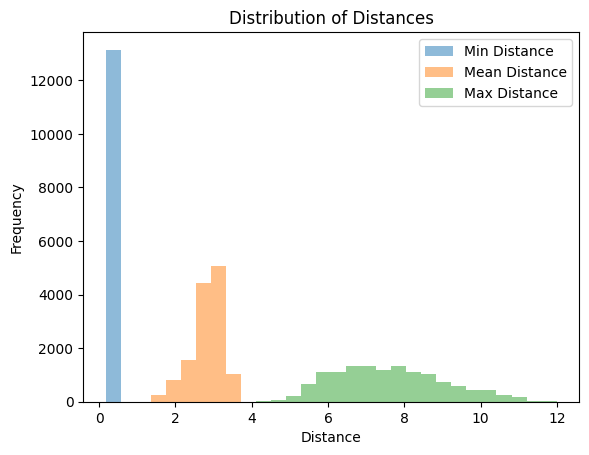

In [28]:
# Visualization

robot_df[['min_dist', 'mean_dist', 'max_dist']].plot.hist(alpha=0.5, bins=30)
plt.title("Distribution of Distances")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.legend(['Min Distance', 'Mean Distance', 'Max Distance'])
plt.show()